In [1]:
from src.models.vae import VAE
from src.trainer import CLEARVAETrainer
from src.utils import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [4]:
from src.utils import StyledMNISTGenerator, StyledMNIST

In [26]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [6]:
np.random.seed(101)
torch.manual_seed(101)

In [7]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


In [8]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3940.49item/s]


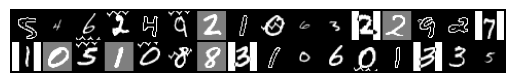

In [12]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


Hamaguchi, et al. (2019) state that the distance/similarity metric between two Gaussians is recommended to take both the $\mu$ and the $\Sigma$ into account. However, these unexpectedly lead to blurring in reconstruction and in turn result in lower gMIG. Therefore, we use `cosine` and `l2` in the constrastive loss.

### cosine sim + label-flipping

In [9]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [1e2, 1e2]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [10]:
trainer.fit(51, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 104.17it/s]


val_recontr_loss=61.631, val_kl_c=10.382, val_kl_s=14.460, val_c_loss=0.269, val_s_loss=0.109
gMIG: 0.188; elbo: -86.473


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 263.19it/s]


val_recontr_loss=32.578, val_kl_c=12.215, val_kl_s=18.628, val_c_loss=0.129, val_s_loss=0.110
gMIG: 0.244; elbo: -63.422


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 270.33it/s]


val_recontr_loss=25.012, val_kl_c=12.958, val_kl_s=19.575, val_c_loss=0.107, val_s_loss=0.110
gMIG: 0.262; elbo: -57.546


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 267.07it/s]


val_recontr_loss=22.453, val_kl_c=13.555, val_kl_s=19.748, val_c_loss=0.097, val_s_loss=0.110
gMIG: 0.266; elbo: -55.756


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 267.29it/s]


val_recontr_loss=20.626, val_kl_c=14.630, val_kl_s=20.185, val_c_loss=0.093, val_s_loss=0.110
gMIG: 0.278; elbo: -55.441


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 257.54it/s]


val_recontr_loss=19.595, val_kl_c=15.260, val_kl_s=20.738, val_c_loss=0.089, val_s_loss=0.111
gMIG: 0.282; elbo: -55.592


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 247.42it/s]


val_recontr_loss=18.660, val_kl_c=15.609, val_kl_s=20.459, val_c_loss=0.093, val_s_loss=0.110
gMIG: 0.279; elbo: -54.729


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 254.91it/s]


val_recontr_loss=17.465, val_kl_c=15.729, val_kl_s=21.214, val_c_loss=0.084, val_s_loss=0.109
gMIG: 0.285; elbo: -54.408


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 260.05it/s]


val_recontr_loss=17.084, val_kl_c=16.109, val_kl_s=21.362, val_c_loss=0.090, val_s_loss=0.109
gMIG: 0.289; elbo: -54.556


val-epoch 45: 100%|██████████| 79/79 [00:00<00:00, 263.34it/s]


val_recontr_loss=17.392, val_kl_c=16.113, val_kl_s=21.406, val_c_loss=0.095, val_s_loss=0.110
gMIG: 0.291; elbo: -54.911


val-epoch 50: 100%|██████████| 79/79 [00:00<00:00, 275.98it/s]


val_recontr_loss=16.548, val_kl_c=16.008, val_kl_s=20.947, val_c_loss=0.087, val_s_loss=0.109
gMIG: 0.293; elbo: -53.503


In [13]:
trainer.evaluate(test_loader, False, 0)

(0.29105521019717595, -53.2994146865016)

In [14]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 286.56it/s]


In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

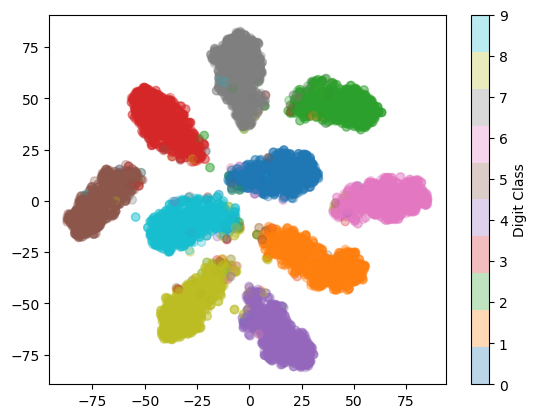

In [19]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

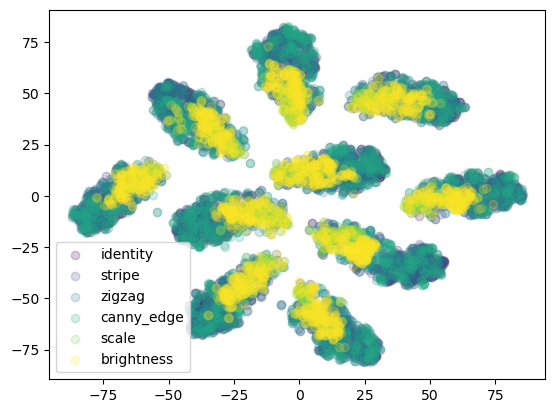

In [20]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [29]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

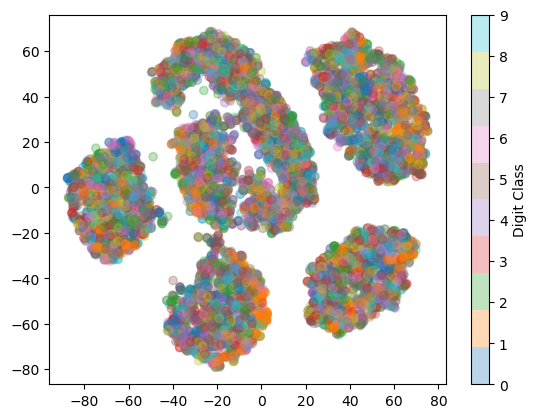

In [30]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

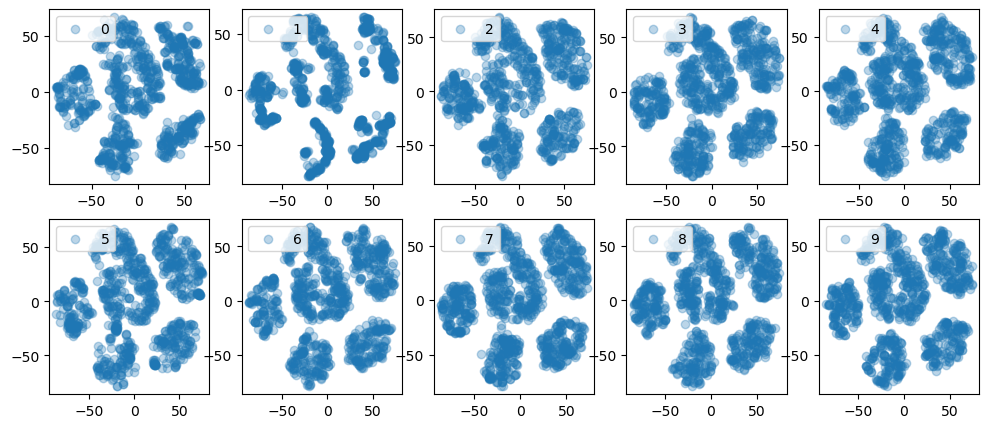

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3, label=f"{i}")
    ax.legend(loc='upper left')

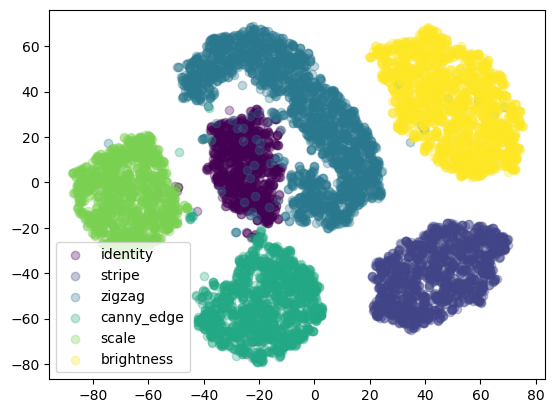

In [31]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [86]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)


### l2 sim + lable-flipping

In [69]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [100, 100]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="l2",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [70]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 240.12it/s]


val_recontr_loss=63.332, val_kl_c=10.708, val_kl_s=9.996, val_c_loss=0.460, val_s_loss=0.123
gMIG: 0.123; elbo: -84.037


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 219.26it/s]


val_recontr_loss=36.467, val_kl_c=14.066, val_kl_s=13.946, val_c_loss=0.178, val_s_loss=0.126
gMIG: 0.197; elbo: -64.48


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 196.35it/s]


val_recontr_loss=28.131, val_kl_c=16.861, val_kl_s=17.266, val_c_loss=0.187, val_s_loss=0.122
gMIG: 0.24; elbo: -62.259


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 195.75it/s]


val_recontr_loss=26.922, val_kl_c=17.470, val_kl_s=19.826, val_c_loss=0.176, val_s_loss=0.117
gMIG: 0.256; elbo: -64.217


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 204.13it/s]


val_recontr_loss=22.146, val_kl_c=18.060, val_kl_s=21.618, val_c_loss=0.181, val_s_loss=0.116
gMIG: 0.265; elbo: -61.825


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 204.48it/s]


val_recontr_loss=21.515, val_kl_c=18.305, val_kl_s=22.850, val_c_loss=0.161, val_s_loss=0.114
gMIG: 0.268; elbo: -62.67


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 195.26it/s]


val_recontr_loss=21.867, val_kl_c=18.312, val_kl_s=23.556, val_c_loss=0.176, val_s_loss=0.114
gMIG: 0.275; elbo: -63.736


In [168]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [169]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

In [ ]:
display_util(9, 26, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [35]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 9
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [53, 88, 62, 67, 73, 85, 71, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### mahalanobis / modified l2 + label flipping

In [96]:
Z_DIM = 16
TEMP = 2
ALPHA = [10, 10]
LABEL_FLIPPING = True

In [99]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="modified_l2",
    hyperparameter={"temperature": TEMP, "beta": 1/2, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=3,
    device=device,
)

In [100]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 110.36it/s]


val_recontr_loss=54.222, val_kl_c=4.790, val_kl_s=5.753, val_c_loss=0.339, val_s_loss=0.154
gMIG: 0.123; elbo: -64.764


val-epoch 3: 100%|██████████| 79/79 [00:00<00:00, 255.80it/s]


val_recontr_loss=34.340, val_kl_c=5.735, val_kl_s=6.233, val_c_loss=0.263, val_s_loss=0.166
gMIG: 0.141; elbo: -46.308


val-epoch 6: 100%|██████████| 79/79 [00:00<00:00, 244.75it/s]


val_recontr_loss=29.682, val_kl_c=6.583, val_kl_s=6.034, val_c_loss=0.310, val_s_loss=0.139
gMIG: 0.155; elbo: -42.298


val-epoch 9: 100%|██████████| 79/79 [00:00<00:00, 243.77it/s]


val_recontr_loss=27.395, val_kl_c=6.836, val_kl_s=6.637, val_c_loss=0.247, val_s_loss=0.147
gMIG: 0.155; elbo: -40.868


val-epoch 12: 100%|██████████| 79/79 [00:00<00:00, 262.10it/s]


val_recontr_loss=26.478, val_kl_c=7.097, val_kl_s=6.753, val_c_loss=0.268, val_s_loss=0.131
gMIG: 0.158; elbo: -40.328


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 253.61it/s]


val_recontr_loss=25.789, val_kl_c=7.063, val_kl_s=7.250, val_c_loss=0.258, val_s_loss=0.151
gMIG: 0.157; elbo: -40.103


val-epoch 18: 100%|██████████| 79/79 [00:00<00:00, 256.52it/s]


val_recontr_loss=24.829, val_kl_c=7.244, val_kl_s=7.261, val_c_loss=0.231, val_s_loss=0.146
gMIG: 0.157; elbo: -39.334


val-epoch 21: 100%|██████████| 79/79 [00:00<00:00, 263.63it/s]


val_recontr_loss=25.090, val_kl_c=7.141, val_kl_s=6.820, val_c_loss=0.233, val_s_loss=0.128
gMIG: 0.156; elbo: -39.051


val-epoch 24: 100%|██████████| 79/79 [00:00<00:00, 269.42it/s]


val_recontr_loss=23.976, val_kl_c=7.204, val_kl_s=7.584, val_c_loss=0.261, val_s_loss=0.153
gMIG: 0.152; elbo: -38.764


val-epoch 27: 100%|██████████| 79/79 [00:00<00:00, 257.81it/s]


val_recontr_loss=23.693, val_kl_c=7.419, val_kl_s=7.612, val_c_loss=0.280, val_s_loss=0.143
gMIG: 0.155; elbo: -38.724


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 259.49it/s]


val_recontr_loss=22.517, val_kl_c=8.168, val_kl_s=8.020, val_c_loss=0.318, val_s_loss=0.147
gMIG: 0.166; elbo: -38.704


In [101]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


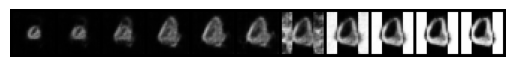

interpolate content:


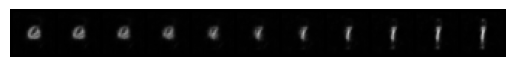

In [102]:
display_util(9, 16, z, vae, int(Z_DIM / 2))

interpolate style:


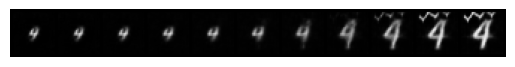

interpolate content:


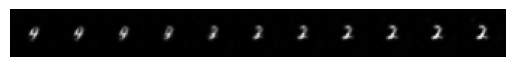

In [103]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


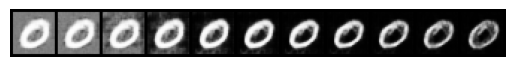

interpolate content:


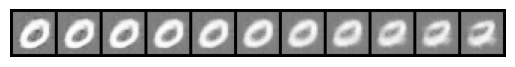

In [104]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


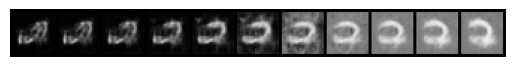

interpolate content:


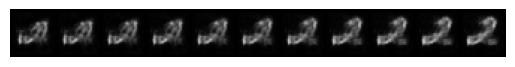

In [85]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


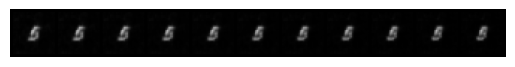

interpolate content:


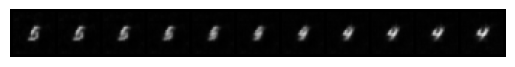

In [86]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [87]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

100%|██████████| 79/79 [00:00<00:00, 289.68it/s]


In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

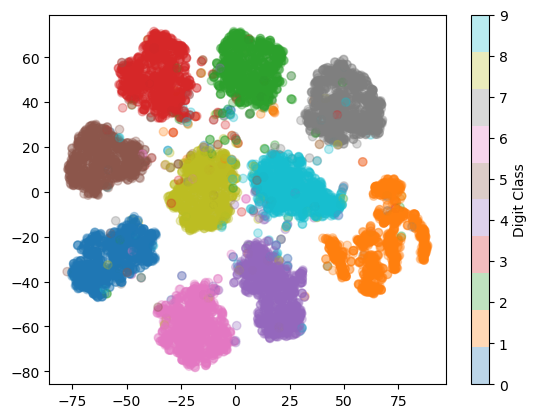

In [89]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

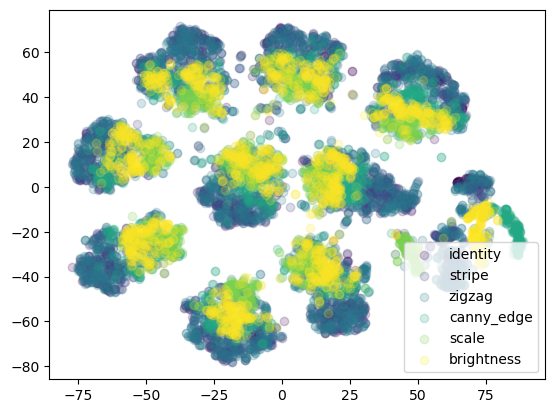

In [90]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [91]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

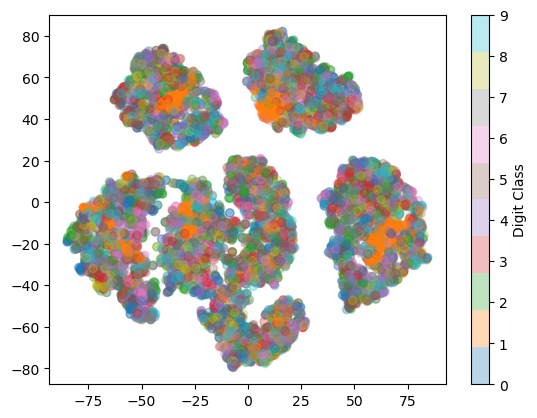

In [92]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

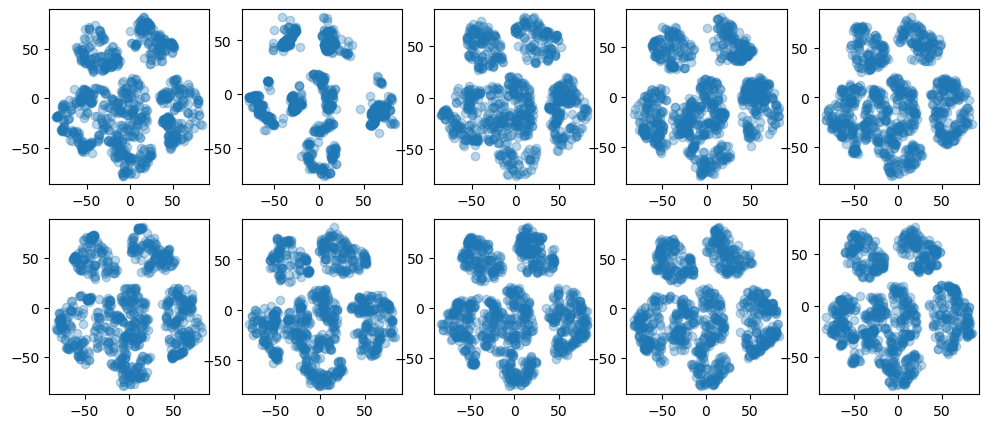

In [93]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

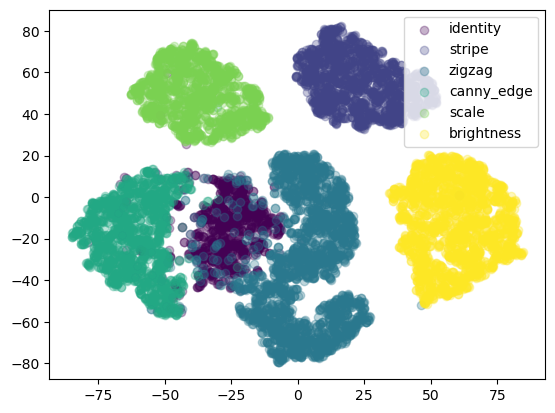

In [94]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [136, 120, 84, 50, 52]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))